## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import time
from IPython.display import display_html
from IPython.core.display import display, HTML

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer 


import warnings
warnings.filterwarnings("ignore")

### Reading the Data and Review

In [2]:
#Reading in our cleaned data set
model_df = pd.read_csv('./data/clean_data.csv')

In [3]:
model_df.head()

,subreddit,text
0,0,AITA for wanting money to fix my book So my li...
1,0,AITA Uninviting my Maid of Honor to my Weddin...
2,0,AITA for not telling my partner about my famil...
3,0,AITA for leaving the group chat So excuse my b...
4,0,WIBTA if I didnt want my gf to come to a conce...


In [4]:
#Checking the number of observations, 2672
model_df.shape

(2672, 2)

In [5]:
#Checkign null values
model_df.isnull().sum()

subreddit    0
text         0
dtype: int64

In [6]:
#Another way to show null values and column data types
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672 entries, 0 to 2671
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  2672 non-null   int64 
 1   text       2672 non-null   object
dtypes: int64(1), object(1)
memory usage: 41.9+ KB


In [7]:

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if w not in stopwords.words('english')]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemma_words)

In [8]:
model_df['clean_text'] = model_df['text'].map(lambda s:preprocess(s))

In [9]:
model_df['clean_text'][8]

'aita forgiving friend month falling mario kart hi allsix month ago h grad friend drinking celebrating got high okay however anxiety dont like largeunfamiliar group however felt safe comfortable close friendslater playing mario kart getting winning bit making bold claim status winner thought knew bragging good faith meant offense calling suckas bantering one friend joel wasnt hot racetrack joel suddenly tuned yelled quite loud saying brag initially smiled competitive fun turned darker started saying awful thing told didnt like saying always frustrating annoying h didnt know completely blindsided sat silent expressed true feeling plus drunkhigh really horrible calling asshole sat stared forward thing two friend didnt step got quite worried maybe wrong didnt respond excused slepta day later one friend bestfriend said joel completely wrong expected apology joel never reached shocked whole thing happened mario kart hear half larger friend group originally including one friend present night

#### Preliminary Text Visualizations

##### Subreddit Distribution

Although we already know that our subreddits are split evenly from our data cleaning, let us create a visualization of the split as well as get a rough estimate of the number of posts in each.

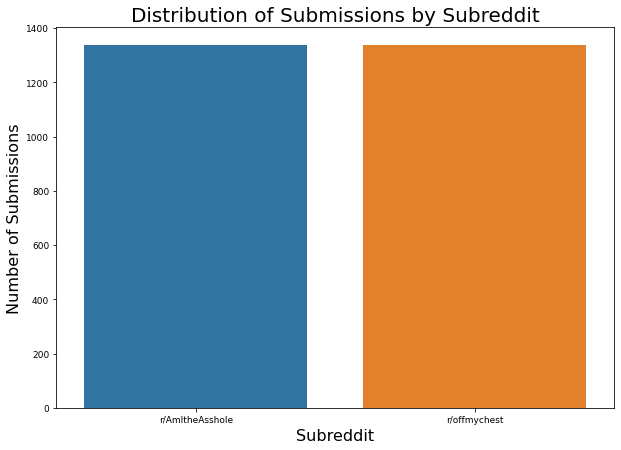

In [10]:

plt.figure(figsize = (10, 7))
sns.countplot(model_df['subreddit'])
plt.title('Distribution of Submissions by Subreddit', size = 20)
plt.xlabel('Subreddit', size = 16)
plt.ylabel('Number of Submissions', size = 16)

plt.xticks([0,1], labels = ['r/AmItheAsshole', 'r/offmychest'], size = 9)
plt.yticks(size = 9);


##### Text Lengths

In [11]:
#List of all post lengths (title + selftext)
text_len = [len(text) for text in model_df["clean_text"]]

In [12]:
#Mean length of text, in words including posts
print(np.mean(text_len))

929.0864520958083


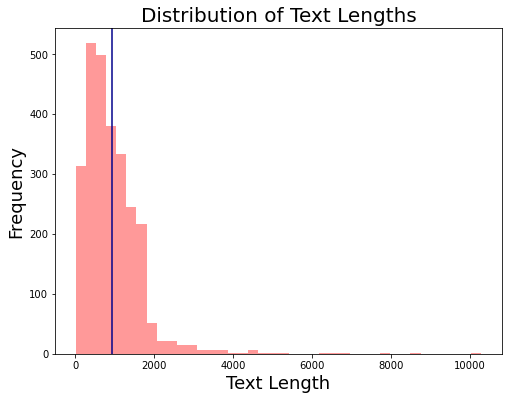

In [13]:
#Plotting 
plt.figure(figsize = (8,6), facecolor = 'white', edgecolor = 'black')
sns.distplot(text_len, kde = False, color = 'red', bins = 40)
plt.axvline(np.mean(text_len), color = 'darkblue')
plt.xlabel('Text Length', size = 18)
plt.ylabel('Frequency', size = 18)
plt.title('Distribution of Text Lengths', size = 20)
plt.savefig('./images/text_dists.png')

plt.show;

#The blue line signifies the mean, which is 929.08 words (which includes the title)


We can see that the majority of posts are less than 2500 words even including the title text. There are a few outliers with >7500 words that we can see with a bin size of 40 which we may check back to if there are issues with our model. These could very well be large spam posts or people really are getting a lot off their chest in their posts.

### Stop Words, Vectorization

We want to first use the count vectorizer to convert our text into a structured dataframe. With this we can look at our most common words for each subreddit and possibly find some insights into our subreddits themselves.

In [14]:

#Instantiating the count vectorizer
cvec = CountVectorizer(stop_words = 'english')

#Creating two so we can fit_transform each one to export for separate lists of word vectors
cvec_1 = CountVectorizer(stop_words = 'english')
cvec_2 = CountVectorizer(stop_words = 'english')

In [15]:
#We will vectorize the individual subreddits for our count of most common words
aita = model_df[model_df['subreddit'] == 0]
omc = model_df[model_df['subreddit'] == 1]

In [16]:
#Fit transforming two different vectorizers
cvec_aita = cvec_1.fit_transform(aita['clean_text'])
cvec_omc = cvec_2.fit_transform(omc['clean_text'])

In [17]:
aita_vectors = pd.DataFrame(cvec_aita.toarray(),
                            columns = cvec_1.get_feature_names())

omc_vectors = pd.DataFrame(cvec_omc.toarray(),
                           columns = cvec_2.get_feature_names())

In [18]:
top_aita_words = aita_vectors.sum().sort_values(ascending = False).head(20)
print(top_aita_words)

im        2010
friend    1888
like      1788
said      1732
told      1708
aita      1638
time      1574
dont      1434
didnt     1327
want      1295
year      1167
know      1157
got       1061
mom       1047
thing     1034
day        984
really     970
feel       940
family     890
going      859
dtype: int64


In [19]:
top_omc_words = omc_vectors.sum().sort_values(ascending = False).head(20)
print(top_omc_words)

im        3020
like      2190
dont      1879
feel      1599
know      1507
time      1410
want      1252
friend    1207
people    1140
year      1123
life      1103
thing     1020
ive       1016
really    1005
day        852
make       764
think      755
didnt      737
got        637
going      619
dtype: int64


Just from a quick glance, we see that there are a few common words such as 'dont', 'im' or 'like'. To interpret this, it makes sense that in subreddits where people are talking about their personal lives and anecdotes, that we will see these phrases. We may want to include these in our stopwords as they may reduce the effectiveness of our model due to the frequency and commonality we see between r/AmItheAsshole and r/offmychest. This also brings into question whether we would do the same for 'AITA' which we see in the list of r/AmItheAsshole common words. Words like 'AITA' or 'asshole' will probably be frequently seen which will benefit our model in differentiating between the two.

In [20]:
#Creating an array of all the shared words using np.intersect1d
shared_words = np.intersect1d(top_aita_words.index, top_omc_words.index) #https://numpy.org/doc/stable/reference/generated/numpy.intersect1d.html | https://stackoverflow.com/questions/48539195/list-of-columns-in-common-in-two-pandas-dataframes
print(shared_words)
print(f'The number of shared words in top 20 most frequent words for each subreddit is: {len(shared_words)}')

['day' 'didnt' 'dont' 'feel' 'friend' 'going' 'got' 'im' 'know' 'like'
 'really' 'thing' 'time' 'want' 'year']
The number of shared words in top 20 most frequent words for each subreddit is: 15


In [21]:
#Adding our shared words to our stopwords
stopwords = stopwords.words('english')

stopwords.extend(shared_words)

In [22]:
#Adding in our AITA terms that denote the subreddit
aita_terms = ['aita', 'wibta', 'asshole']


In [23]:
stopwords.extend(aita_terms)

In [24]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Modeling

Setting Up Our Data

In [28]:
X = model_df['clean_text']
y = model_df['subreddit']

##### Train-Test Split

In [29]:
#Setting up random state as 42
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 42,
                                                    stratify = y)

In [30]:
#We will create a function to help return evaluation metrics of our models source: https://buhrmann.github.io/tfidf-analysis.html
def class_report(confusion_matrix):
    tp, fp, fn, tn = confusion_matrix.flatten()
    measures = {}
    measures['accuracy'] = (tp + tn) / (tp + fp + fn + tn)
    measures['specificity'] = tn / (tn + fp)        # (true negative rate)
    measures['sensitivity'] = tp / (tp + fn)        # (recall, true positive rate)
    measures['precision'] = tp / (tp + fp)
    measures['f1score'] = 2*tp / (2*tp + fp + fn)
    return measures


### Logistic Regression

We explored what our baseline model would be in our EDA, which is a 50/50 split in terms of classification for the subreddits. We will start with a simple logistic regression with gridsearch.

In [31]:
#Instantiating pipeline
lr_cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('log_reg', LogisticRegression())
])

#Setting params for the Count Vectorizer
lr_cvec_params = {
    'cvec__max_features' : [10, 25, 200,500,1000,2000],
    'cvec__ngram_range'  : [(1,1), (1,2), (1,3), (1,4)],
    'cvec__min_df'       : [0.02, 0.05],
    'cvec__max_df'       : [0.9, 0.95],
    'cvec__stop_words'   : [stopwords]
}

lr_cvec_gs = GridSearchCV(estimator = lr_cvec_pipe,
                          param_grid = lr_cvec_params,
                          cv = 5,
                          n_jobs = -1,
                          verbose = 1)

In [32]:
#Fitting our model onto training data
lr_cvec_gs.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [10, 25, 200, 500, 1000, 2000],
                         'cvec__min_df': [0.02, 0.05],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
            

In [33]:
print(f'The best score using our GridSearchCV on a Logistic Regression is: {lr_cvec_gs.best_score_}')

The best score using our GridSearchCV on a Logistic Regression is: 0.8537955112219452


In [34]:
log_best_params = lr_cvec_gs.best_params_
print(log_best_params)

{'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 0.02, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', '

In [35]:
print(f'Our score for the training data is: {lr_cvec_gs.score(X_train, y_train)}')

Our score for the training data is: 0.998003992015968


In [36]:
print(f'Our score for the testing data is: {lr_cvec_gs.score(X_test, y_test)}')

Our score for the testing data is: 0.8547904191616766


Remarkably, our basic logistic regression model appears to be very strong with a training score near 100% and a testing score around 87.4%. Our model is very overfit by the looks of it and it may be due to the size of the dataset or the model is pucking up a lot of noise from the data. We will take a look at the confusion matrices below and calculate our accuracy score which we will use as our evaluation metric to compare to the baseline model. However, our model is slightly overfit which is a tendency of linear models. 

##### Confusion Matrices and Accuracy Score

In [37]:
#Setting up our predicted y-values
train_preds = lr_cvec_gs.predict(X_train)
preds = lr_cvec_gs.predict(X_test)

The accuracy score on our training data is: 0.998003992015968


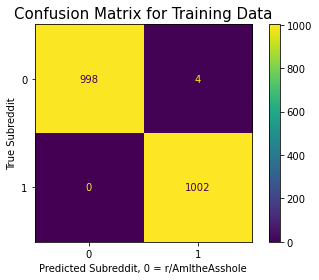

In [38]:
#Training Data Confusion matrix
cm = confusion_matrix(y_train, train_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Training Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')

lr_train_accuracy = accuracy_score(y_train, train_preds)
print(f'The accuracy score on our training data is: {accuracy_score(y_train, train_preds)}')

{'accuracy': 0.8547904191616766,
 'specificity': 0.8414985590778098,
 'sensitivity': 0.8691588785046729,
 'precision': 0.8353293413173652,
 'f1score': 0.8519083969465648}

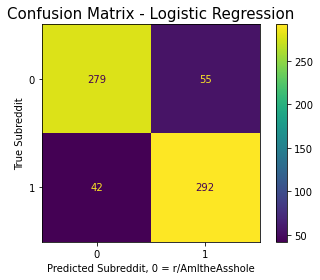

In [39]:
#Testing Data Confusion Matrix
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()


plt.title('Confusion Matrix - Logistic Regression', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')



lr_test_accuracy = accuracy_score(y_test, preds)
class_report(cm)



### Support Vector Classifier (SVC)

Here we will compare our logistic regression results to our support vector machine. We hope that our SVM will aid in the over-fitting due to the fact that it uses regularization. SVMs will linearly separate the data and we will explore if using a kernel will also help with reducing our overfitness.

In [40]:

#Instantiating our SVC pipe
svc_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

#Params, setting up C and gamma as we'd expect the better model to include RBF
svc_params = {
    'cvec__max_features' : [350,700,1400],
    'cvec__ngram_range'  : [(1,2)],
    'cvec__stop_words'   : [stopwords],
    'cvec__min_df'       : [0.02],
    'cvec__max_df'       : [.9],
    'svc__C'             : np.logspace(-5, 2, 10),
    'svc__kernel'        : ['poly', 'rbf', 'linear'],
    'svc__gamma'         : ['scale', 'auto']
    }

#Setting up our GridSearchCV with the SVC pipe and params
svc_gs = GridSearchCV(estimator = svc_pipe,
                      param_grid = svc_params,
                      cv = 5,
                      verbose = 1,
                      n_jobs = -1)



In [41]:
#Including time calculation to see how long it'll take to execute. 
start = time.time()

svc_gs.fit(X_train, y_train)

end = time.time()
print(f'Elapsed Time to Execute: {end-start}')

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Elapsed Time to Execute: 274.45216178894043


In [42]:
svc_best_params = svc_gs.best_params_
print(svc_best_params)

{'cvec__max_df': 0.9, 'cvec__max_features': 1400, 'cvec__min_df': 0.02, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', '

##### Confusion Matrix and Accuracy Scores

In [43]:
#Creating predictions off our training and testing data
svc_train_preds = svc_gs.predict(X_train)
svc_test_preds = svc_gs.predict(X_test)

The accuracy score on our training data is: 0.9870259481037924


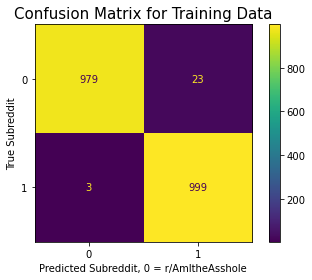

In [44]:
#Training Data Confusion matrix
cm = confusion_matrix(y_train, svc_train_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Training Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')

svc_train_accuracy = accuracy_score(y_train, svc_train_preds)
print(f'The accuracy score on our training data is: {svc_train_accuracy}')

{'accuracy': 0.8727544910179641,
 'specificity': 0.8608695652173913,
 'sensitivity': 0.8854489164086687,
 'precision': 0.8562874251497006,
 'f1score': 0.8706240487062404}

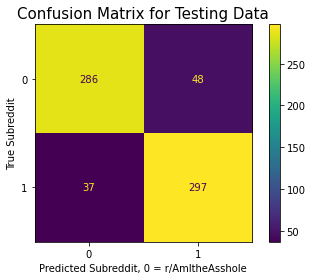

In [45]:
#Testing Data Confusion matrix
cm = confusion_matrix(y_test, svc_test_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Testing Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')

svc_test_accuracy = accuracy_score(y_test, svc_test_preds)
class_report(cm)

As we can see in comparison to our logistic regression model, our SVC model seems to perform better, with it not being extremely overfit. Although it did not improve our testing accuracy score by much, we still have a fairly decent score of 87.72%. As we can see, our C value is 2.78 as we used a logspace. Maybe we can hypertune this to see if we can marginally improve our score. We will also include different degrees for poly to see how it fares in the grid search against our original model. 

In [46]:
#Instantiating our SVC pipe
svc_pipe_ = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

#Keeping the best params from our initial SVC model, we will explore different options for C
svc_params = {
    'cvec__max_features' : [700],
    'cvec__ngram_range'  : [(1,2), (1,1)],
    'cvec__stop_words'   : [stopwords],
    'cvec__min_df'       : [0.05],
    'cvec__max_df'       : [.9],
    'svc__C'             : np.linspace(0, 5, 30),
    'svc__kernel'        : ['rbf', 'poly'],
    'svc__gamma'         : ['auto'],
    'svc__degree'        : [1,2]
    }

#Setting up our GridSearchCV with the SVC pipe and params
svc_gs = GridSearchCV(estimator = svc_pipe,
                      param_grid = svc_params,
                      cv = 5,
                      verbose = 1,
                      n_jobs = -1)



In [47]:

start = time.time()

svc_gs.fit(X_train, y_train)

end = time.time()
print(f'Elapsed Time to Execute: {end-start}')

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Elapsed Time to Execute: 170.95726823806763


In [48]:
#Taking a look at our best parameter for C
print(svc_gs.best_params_['svc__C'])
print(svc_gs.best_params_['svc__kernel'])
print(svc_gs.best_params_['svc__degree'])
print(svc_gs.best_params_['cvec__ngram_range'])

5.0
rbf
1
(1, 1)


In [49]:
#Taking a quick peek at our scores to see if there are any marginal improvements in tweaking the C-score
print(svc_gs.score(X_train, y_train))
print(svc_gs.score(X_test, y_test))

0.9530938123752495
0.8622754491017964


From a quick glance, it doesnt seem adjusting the C-value as a hyperparameter has done much. The best parameter we see for 'svc__C' in our grid search is 5 which is a slight change from our original C parameter value. 

The accuracy score on our training data is: 0.9530938123752495


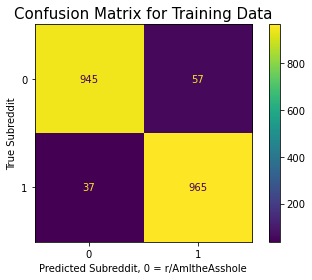

In [50]:
#Training Data Confusion matrix - SVC
svc_train_preds_2 = svc_gs.predict(X_train)
svc_test_preds_2 = svc_gs.predict(X_test)

cm = confusion_matrix(y_train, svc_train_preds_2)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Training Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')

svc_train_accuracy_2 = accuracy_score(y_train, svc_train_preds_2)
print(f'The accuracy score on our training data is: {svc_train_accuracy_2}')

{'accuracy': 0.8622754491017964,
 'specificity': 0.8361111111111111,
 'sensitivity': 0.8928571428571429,
 'precision': 0.8233532934131736,
 'f1score': 0.8566978193146417}

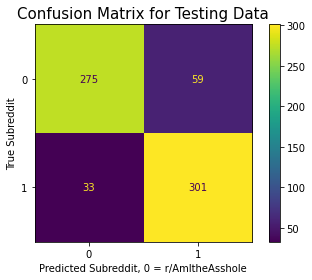

In [51]:
#Testing Data Confusion matrix - SVC
cm = confusion_matrix(y_test, svc_test_preds_2)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Testing Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')

svc_test_accuracy_2 = accuracy_score(y_test, svc_test_preds_2)
class_report(cm)

Overall, the support vector classifier has been a major improvement over the logistic regression, where we don't see a 100% accuracy score on the training data. We could attribute it to the fact that support vector machines are effective with high-dimensional data and makes sense with our problem statement in that its finding the best way to differentiate between the two subreddits using a hyperplane. By using the SVC, we were able to reduce our overfitness by an accuracy score of 0.04 which is what we expected.

### Random Forest

Now we move to the Random Forest Classifier. Using this classifier should aid in the high variance we are dealing with in that it will de-correlate decision trees in the model due to the selection of random subsets of features in the learning algorithm. In addition to that, the bootstrapping built into the algorithm which randomly sub-samples our data should reduce variance in its aggregation of individual models. 

In [52]:
rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state = 42))
])

rf_pipe_params = {
    'cvec__max_features' : [None, 750],
    'cvec__ngram_range'  : [(1,2)],
    'cvec__stop_words'   : [stopwords],
    'rf__n_estimators'   : [30,100,300,600,800],
    'rf__max_depth'      : [15],
    'rf__min_samples_split': [3,6],
    'rf__min_samples_leaf': [2],
    'rf__max_features'   : [10,25,50],
    
}

rf_gs = GridSearchCV(estimator = rf_pipe,
                     param_grid = rf_pipe_params,
                     cv = 5,
                     n_jobs = -1,
                     verbose = 1)

In [53]:


start = time.time()

rf_gs.fit(X_train, y_train)

end = time.time()
print(f'Elapsed Time to Execute: {end-start}')

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Elapsed Time to Execute: 92.69463896751404


In [54]:
rf_gs.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=750, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf',
                 RandomForestClassifier(max_depth=15, max_features=50,
                                        min_samples_leaf=2, min_samples_split=6,
                                        n_estimators=800, random_state=42))])

The accuracy score on our training data is: 0.9670658682634731


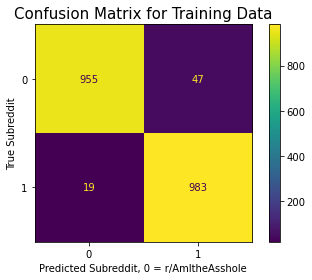

In [55]:
#Training Data Confusion matrix - Random Forest
rf_train_preds = rf_gs.predict(X_train)
rf_test_preds = rf_gs.predict(X_test)

cm = confusion_matrix(y_train, rf_train_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Training Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')

rf_train_accuracy = accuracy_score(y_train, rf_train_preds)
print(f'The accuracy score on our training data is: {rf_train_accuracy}')

The accuracy score on our training data is: 0.8532934131736527


{'accuracy': 0.8532934131736527,
 'specificity': 0.8575757575757575,
 'sensitivity': 0.849112426035503,
 'precision': 0.8592814371257484,
 'f1score': 0.8541666666666666}

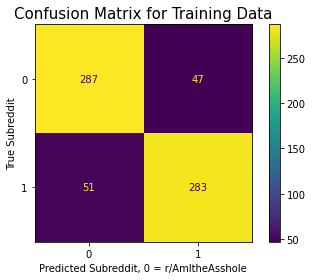

In [56]:
#Testing Data Confusion Matrix - Random Forest
cm = confusion_matrix(y_test, rf_test_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Training Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')

rf_test_accuracy = accuracy_score(y_test, rf_test_preds)
print(f'The accuracy score on our training data is: {rf_test_accuracy}')

class_report(cm)

Surprisingly, despite our hopes for the Random Forest Classifier, it seems it overfits more than the SVC. The silver lining to our Random Forest model is that the number of false positives has finally decreased or at least the ratio to the false negatives. With this in mind, it is interesting to see that our Random Forest model has the best specificity score, but that doesn't mean that this is a great model in comparison to our past models. This just may be due to the number of features we have or just the overall size of the training data. We will adjust the hyper parameters to see if we can adjust our model.

In [57]:
#This model will have a lot less in number of trees and depth. 
rf_pipe_2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state = 80))
])

rf_pipe_params_2 = {
    'cvec__max_features' : [1000],
    'cvec__ngram_range'  : [(1,5)],
    'cvec__min_df'       : [.03],
    'cvec__stop_words'   : [stopwords],
    'rf__bootstrap'      : [True, False],
    'rf__n_estimators'   : [35, 100],
    'rf__max_depth'      : [None, 5, 12],
    'rf__min_samples_split': [8, 16],
    'rf__max_features'   : [None, 'log2', 'auto', .01, 10, 50],
    
}

rf_gs_2 = GridSearchCV(estimator = rf_pipe_2,
                     param_grid = rf_pipe_params_2,
                     cv = 5,
                     n_jobs = -1,
                     verbose = 1)

In [58]:
#Fitting our second random forest grid search
start = time.time()
rf_gs_2.fit(X_train, y_train)
end = time.time()
print(f'Time Elapsed to Execute Code: {end-start}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Time Elapsed to Execute Code: 421.9443368911743


The accuracy score on our training data is: 0.9970059880239521


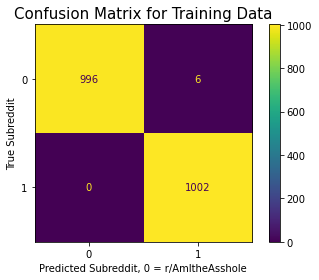

In [59]:
#Training Data Confusion matrix - Random Forest, Version 2
rf_train_preds_2 = rf_gs_2.predict(X_train)
rf_test_preds_2 = rf_gs_2.predict(X_test)

cm = confusion_matrix(y_train, rf_train_preds_2)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Training Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')

rf_train_accuracy_2 = accuracy_score(y_train, rf_train_preds_2)
print(f'The accuracy score on our training data is: {rf_train_accuracy_2}')

The accuracy score on our training data is: 0.875748502994012


{'accuracy': 0.875748502994012,
 'specificity': 0.9061488673139159,
 'sensitivity': 0.8495821727019499,
 'precision': 0.9131736526946108,
 'f1score': 0.8802308802308803}

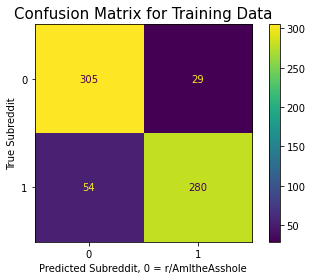

In [80]:
#Testing Data Confusion Matrix - Random Forest, Version 2
cm = confusion_matrix(y_test, rf_test_preds_2)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Training Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')
plt.savefig('./images/confusion_matrix_best_model.png')

rf_test_accuracy_2 = accuracy_score(y_test, rf_test_preds_2)
print(f'The accuracy score on our training data is: {rf_test_accuracy_2}')

class_report(cm)

In [61]:
rf_gs_2.best_params_

{'cvec__max_features': 1000,
 'cvec__min_df': 0.03,
 'cvec__ngram_range': (1, 5),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',


In using a gridsearch where our Random Forest is a bit scaled down in the hyperparameters, we can see an improvement in our random forest model in terms of our accuracy score on our testing data. Our random state is also set to a different number which may also a play a part in the difference of our score. 

#### Random Forest with TFIDF Vectorizer

With how overfit the Random Forest model was, we want to run a last model but using the Term Frequency-Inverse Document Frequency(TF-IDF) Vectorizer. This vectorizer should discount very common words and highlight words that are very specific to a certain post. The weight that is added to these words may help in differentiating the two subreddits. 

In [62]:
#Instantiating a Tfid Vectorizer in our pipe
tvec_rf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state = 80))
])

#Using best parameters set by our past gridsearch on our initial RF model
tvec_pipe_params = {
    'tvec__max_features' : [300, 750,1500, 3000],
    'tvec__ngram_range'  : [(1,2), (1,1), (1,3)],
    'tvec__stop_words'   : [stopwords],
    'rf__n_estimators'   : [200,800, 1500],
    'rf__max_depth'      : [15],
    'rf__min_samples_leaf': [2],
    'rf__max_features'   : [25, 50],
    
}

tvec_rf_gs = GridSearchCV(estimator = tvec_rf_pipe,
                     param_grid = tvec_pipe_params,
                     cv = 5,
                     n_jobs = 4,
                     verbose = 1)

In [63]:
#Fitting it to our training data
start = time.time()

tvec_rf_gs.fit(X_train, y_train)

end = time.time()
print(f'Elapsed Time to Execute: {end-start}')


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Elapsed Time to Execute: 535.9179854393005


In [64]:
rf_best_params = tvec_rf_gs.best_params_
print(rf_best_params)

{'rf__max_depth': 15, 'rf__max_features': 50, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 800, 'tvec__max_features': 1500, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', '

The accuracy score on our training data is: 0.9820359281437125


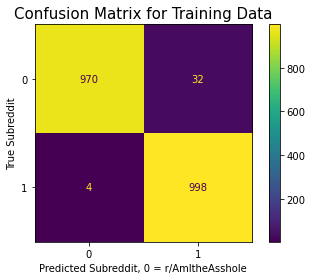

In [65]:
#Training Data Confusion matrix - Random Forest, TFIDF
tvec_train_preds = tvec_rf_gs.predict(X_train)


cm = confusion_matrix(y_train, tvec_train_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Training Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')

tvec_train_accuracy = accuracy_score(y_train, tvec_train_preds)
print(f'The accuracy score on our training data is: {tvec_train_accuracy}')

{'accuracy': 0.8637724550898204,
 'specificity': 0.8584070796460177,
 'sensitivity': 0.8693009118541033,
 'precision': 0.8562874251497006,
 'f1score': 0.8627450980392157}

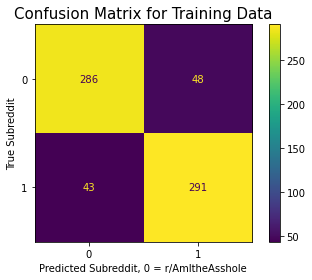

In [66]:
#Testing Data Confusion matrix - Random Forest, TFIDF
tvec_test_preds = tvec_rf_gs.predict(X_test)

cm = confusion_matrix(y_test, tvec_test_preds)
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay(cm).plot()

plt.title('Confusion Matrix for Training Data', size = 15)
plt.xlabel('Predicted Subreddit, 0 = r/AmItheAsshole')
plt.ylabel('True Subreddit')

tvec_test_accuracy = accuracy_score(y_test, tvec_test_preds)
class_report(cm)

Even with the TFIDF Vectorizer, we still had an overfit model much like our initial RF model. Interestingly enough, we see the least disparity when it came to the specificity and sensitivity, where they are both around the same relative value (0.86-0.87), as well as our precision and accuracy.

### Evaluation Exports

Here we will create a dataframe 

In [67]:
#Creating lists with our accuracy scores
test_scores = [lr_test_accuracy, svc_test_accuracy, svc_test_accuracy_2, rf_test_accuracy, rf_test_accuracy_2, tvec_test_accuracy]
train_scores = [lr_train_accuracy, svc_train_accuracy, svc_train_accuracy_2, rf_train_accuracy, rf_train_accuracy_2, tvec_train_accuracy]

In [68]:
#Creating a dataframe with our scores
scores_df = pd.DataFrame(data = [train_scores, test_scores],
                         columns = ['Log-Reg', 'SVC', 'SVC-tuned', 'Random Forest', 'Random Forest - tuned','Random Forest + TF-IDF'],
                         index = ['Train Accuracy Score', 'Test Accuracy Score'])

In [69]:
scores_df

,Log-Reg,SVC,SVC-tuned,Random Forest,Random Forest - tuned,Random Forest + TF-IDF
Train Accuracy Score,0.998004,0.987026,0.953094,0.967066,0.997006,0.982036
Test Accuracy Score,0.854790,0.872754,0.862275,0.853293,0.875749,0.863772


In [79]:
#Saving as .csv for our metrics
scores_df.to_csv('./data/model_metrics_table.csv', index = False)

#### Random Forest Top Features

In [73]:
#Instantiating new cvec and random forest
cvec = CountVectorizer(stop_words = stopwords, ngram_range = (1,3), max_features= 1500)


rf = RandomForestClassifier(random_state = 80, n_estimators = 800, max_depth = 15, min_samples_leaf = 2, max_features = 50)

In [74]:
X_train_vec = cvec.fit_transform(X_train)
X_test_vec = cvec.transform(X_test)

In [75]:
#Fitting on random forest with parameters we found using GridSearch
rf.fit(X_train_vec, y_train)

RandomForestClassifier(max_depth=15, max_features=50, min_samples_leaf=2,
                       n_estimators=800, random_state=80)

In [76]:
#Creating dataframe of our words
X_train_vectors = pd.DataFrame(X_train_vec.toarray(),
                            columns = cvec.get_feature_names())


In [77]:
X_train_vectors

,able,absolutely,abuse,abused,abusive,accept,accepted,accident,accidentally,account,...,yes,yesterday,yet,yo,youd,young,younger,youngest,youre,youve
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,0,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


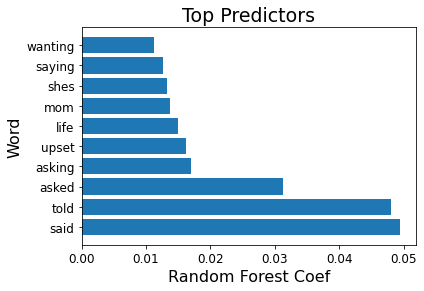

<Figure size 936x936 with 0 Axes>

In [78]:
#Creating a barchart showing our top predictors in the random forest model
sorted_idx = rf.feature_importances_.argsort()[::-1]



plt.barh(X_train_vectors.columns[sorted_idx][0:10], rf.feature_importances_[sorted_idx][0:10])
plt.title('Top Predictors', fontsize = 19)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('Word', fontsize = 16)
plt.xlabel('Random Forest Coef', fontsize = 16)
plt.savefig('./images/top_predictors.png')
plt.figure(figsize = (13,13))




plt.show;



We can see that our more important features were 'said', 'told', 'asked', 'asking', and 'upset'. The frequency of gerunds as well as the similarity of 'asking' and 'asked' has us concerned with how we cleaned our features and how they were vectorized. In future tuning of the models, it would be recommended to explore stemming to remove these similar words. 